# Imports

In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("scripts")
import warnings

from clustermaps import draw_clustermaps, draw_consensus_clustermap
from expressions_EDA import load_expressions_from_s3, renormalize_tpm
from expressions_PCA import compute_pca_all, compute_pca_by_dataset, plot_pca

warnings.filterwarnings("ignore", category=UserWarning)

# Dataset selection and sample list generation

In [2]:
blood_all_annotation = pd.read_csv("../data/annotations_all.csv", index_col="Sample")

/tmp/ipykernel_153975/3228725851.py:1: DtypeWarning: Columns (17,29,33,34,35,36,37,42,44,45,47) have mixed types. Specify dtype option on import or set low_memory=False.
  blood_all_annotation = pd.read_csv("../data/annotations_all.csv", index_col="Sample")


In [3]:
datasets = [
    "GSE124400",
    "GSE143507",
    "PRJNA516296",
    "PRJNA449520",
    "GSE67401",
    "GSE191328",
    "GSE151161",
    "GSE124284",
    "GSE116006",
    "GSE112594",
    "GSE113883",
]


ann = blood_all_annotation[blood_all_annotation["Dataset"].isin(datasets)]
ann.Dataset.unique()

array(['GSE124284', 'GSE124400', 'GSE112594', 'GSE143507', 'GSE67401',
       'GSE113883', 'GSE116006', 'PRJNA516296', 'PRJNA449520',
       'GSE191328', 'GSE151161'], dtype=object)

In [6]:
filtered_ann = ann[
    (ann["Tissue_stimulation"] == "Without_stimulation")
    & (ann["Readcounts"] > 500000)
    & (~ann["Library_preparation_kit"].str.contains("Ion Torrent", na=False))
    & (ann["Sample_type"] == "Whole_blood")
]

print("Filtered annotations:")
print(filtered_ann["Diagnosis"].value_counts())

Filtered annotations:
Diagnosis
Type_1_diabetes_mellitus                                                 968
Systemic_lupus_erythematosus                                             468
Healthy                                                                  153
Crohn_disease                                                            101
Systemic_inflammatory_response_syndrome                                   80
Systemic_inflammatory_response_syndrome, Injury_of_kidney_unspecified     53
Name: count, dtype: int64


In [7]:
filtered_ann.to_csv("../data/annotations_filtred_for_corr.csv")

In [8]:
samples = list(filtered_ann.index)

# Loading and preprocessing the TPM expression matrix

## from S3 

In [ ]:
expr = load_expressions_from_s3(samples=samples, output_path="../data/expression_for_corr.csv")

## Alternative: Use preloaded expression_for_corr.csv"

In [10]:
expressions = pd.read_csv("../data/expression_for_corr.csv", index_col=0)
ann = filtered_ann

In [11]:
with open("../data/genes_v2.txt", "r") as f:
    genes_in_expression = [line.rstrip("\n") for line in f]

existing_genes = set(genes_in_expression) & set(expressions.index)
print(len(genes_in_expression))
print(len(existing_genes))

18792
13290


In [12]:
normalized_expressions = renormalize_tpm(expressions, existing_genes)
log_normalized_expressions = np.log2(normalized_expressions + 1)

In [13]:
expr = log_normalized_expressions
ann = filtered_ann

common_samples = list(set(expr.columns) & set(ann.index))

expr_filtered = expr[common_samples]
datasets = ann.loc[common_samples, ["Dataset", "Diagnosis", "Sample_type"]]

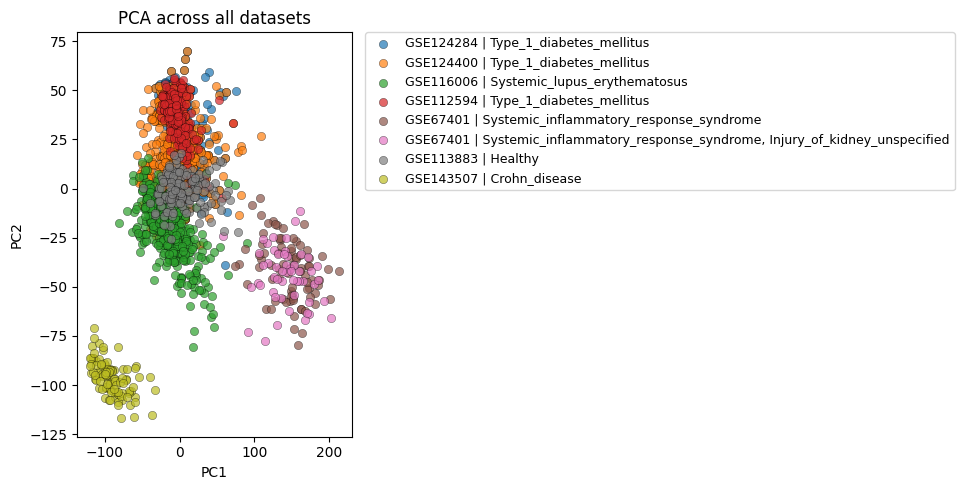

In [14]:
pca_all = compute_pca_all(expr, ann)
plot_pca(pca_all, title="PCA across all datasets", per_dataset=False)

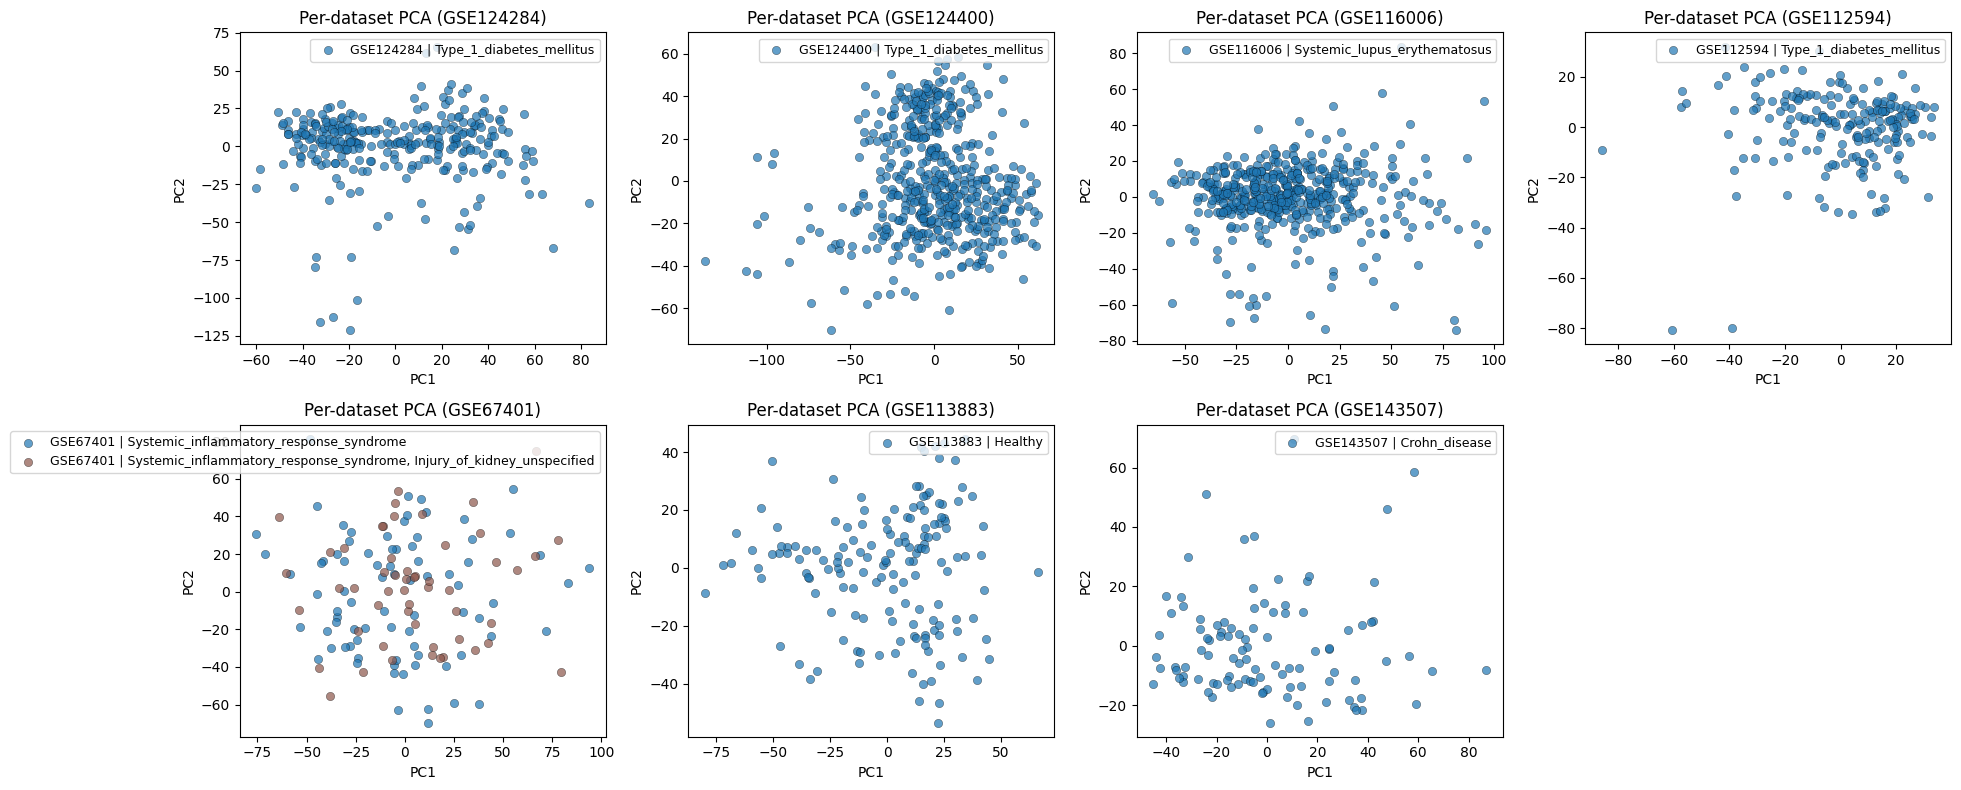

In [15]:
pca_multi = compute_pca_by_dataset(expr_filtered, ann, sample_type="Whole_blood")
plot_pca(pca_multi, title="Per-dataset PCA", per_dataset=True)

In [16]:
pca_multi.query("Dataset == 'GSE112594' and PC2 < -60")

,PC1,PC2,Dataset,Diagnosis,Sample_type,Sample
Sample,,,,,,
SRX3872760,-39.126243,-80.089558,GSE112594,Type_1_diabetes_mellitus,Whole_blood,SRX3872760
SRX3872726,-60.662728,-80.772823,GSE112594,Type_1_diabetes_mellitus,Whole_blood,SRX3872726


In [17]:
pca_multi.query("Dataset == 'GSE112594' and PC1 < -70")

,PC1,PC2,Dataset,Diagnosis,Sample_type,Sample
Sample,,,,,,
SRX3872664,-85.955897,-9.265366,GSE112594,Type_1_diabetes_mellitus,Whole_blood,SRX3872664


In [18]:
samples_to_remove = ["SRX3872726", "SRX3872760", "SRX3872664"]
samples_to_remove_expr = [
    sample for sample in samples_to_remove if sample in expr.columns
]
expr = expr.drop(columns=samples_to_remove_expr)
expr.to_csv("../data/expression_for_corr_filtred.csv")

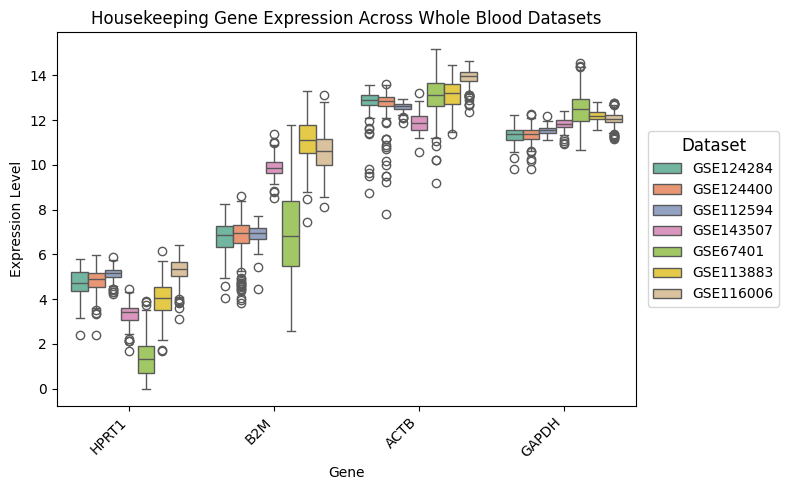

In [19]:
housekeeping_genes = ["GAPDH", "ACTB", "B2M", "HPRT1", "RPLP0"]
existing_housekeeping = list(set(housekeeping_genes) & set(expr.index))

expr_housekeeping = expr.loc[existing_housekeeping].T
expr_housekeeping = expr_housekeeping.join(ann[["Dataset"]])
expr_melted = expr_housekeeping.melt(
    id_vars=["Dataset"], var_name="Gene", value_name="Expression"
)


plt.figure(figsize=(8, 5))
sns.boxplot(
    data=expr_melted,
    x="Gene",
    y="Expression",
    hue="Dataset",
    palette="Set2",
    dodge=True,
)

plt.xticks(rotation=45, ha="right")
plt.title("Housekeeping Gene Expression Across Whole Blood Datasets")
plt.xlabel("Gene")
plt.ylabel("Expression Level")
plt.legend(
    title="Dataset",
    fontsize=10,
    title_fontsize=12,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
)
plt.tight_layout()
plt.show()

# Clustermaps for each dataset

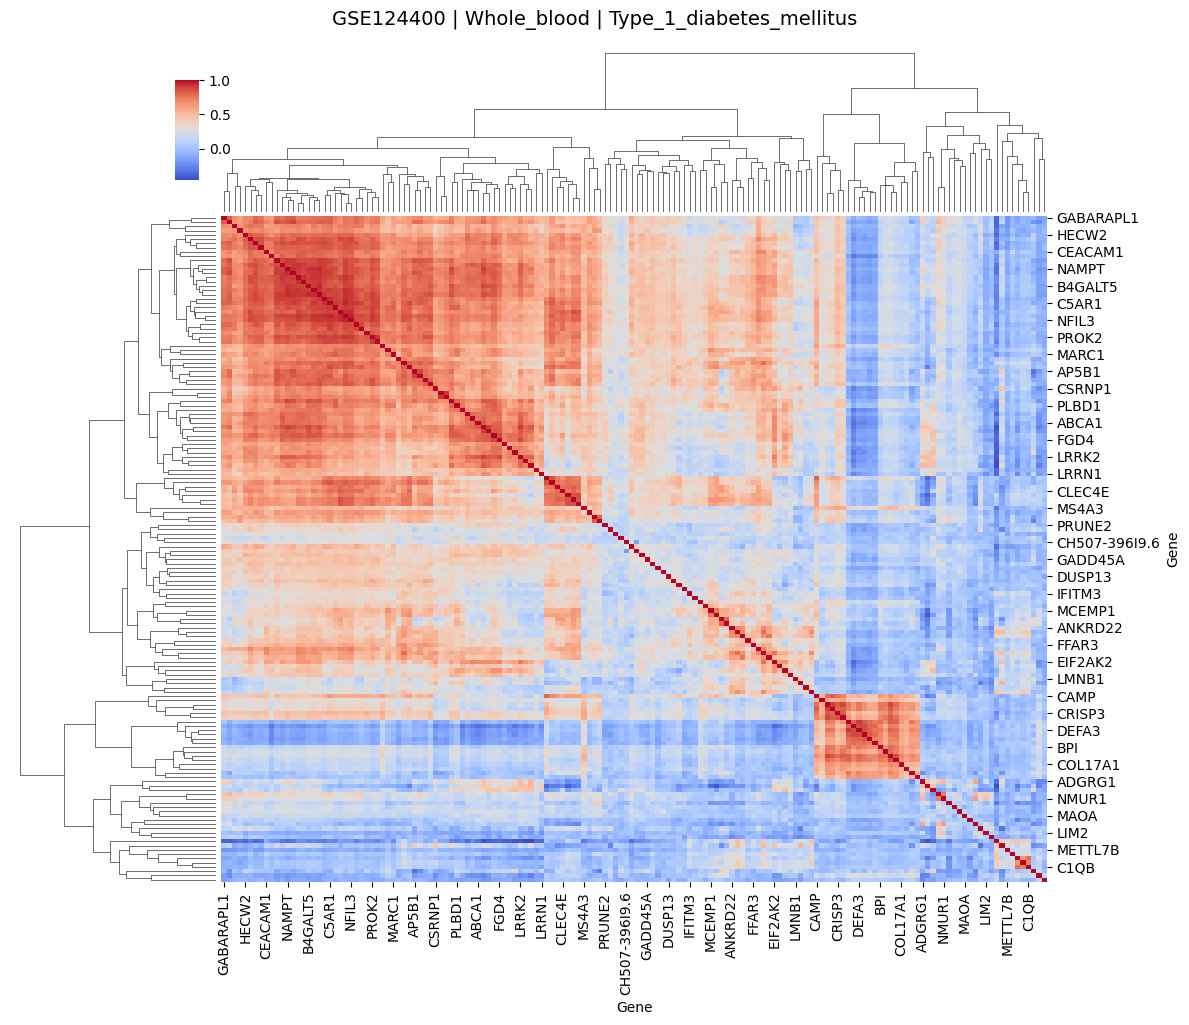

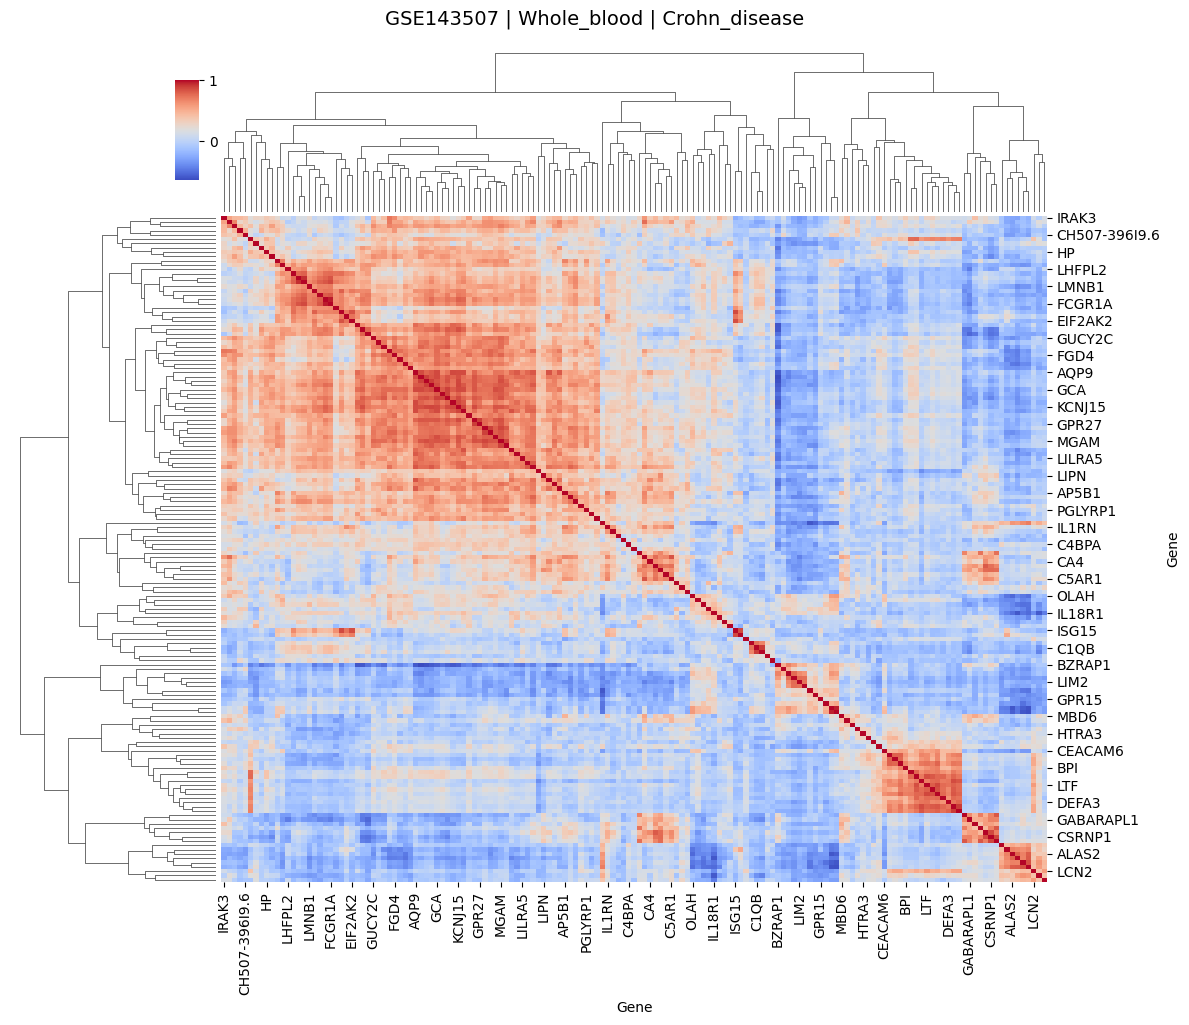

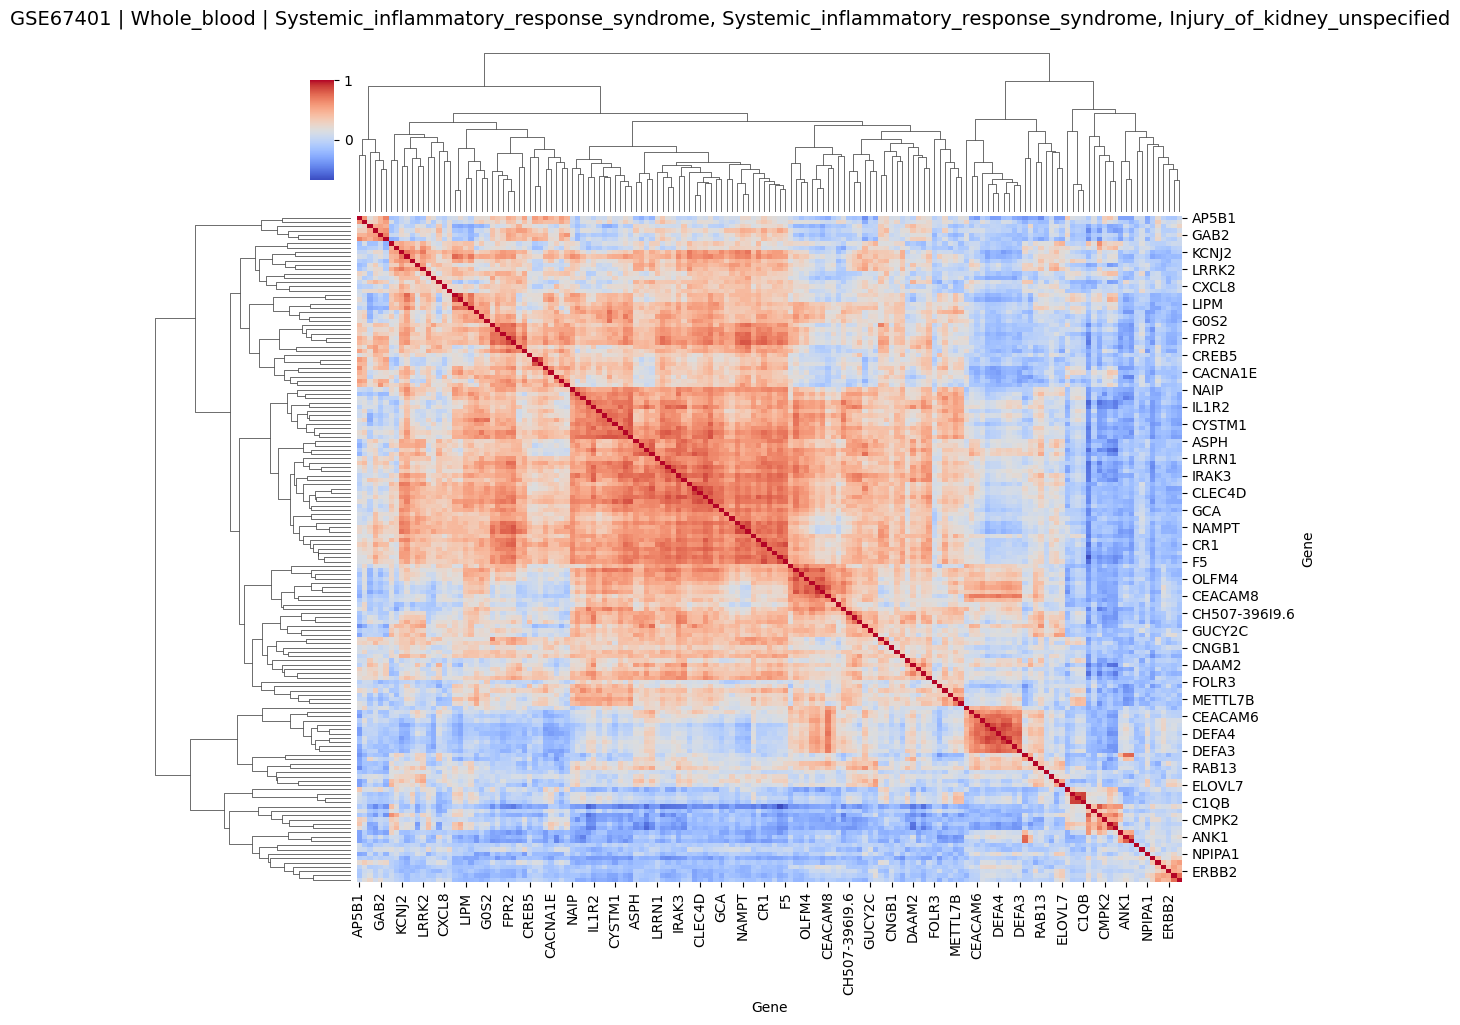

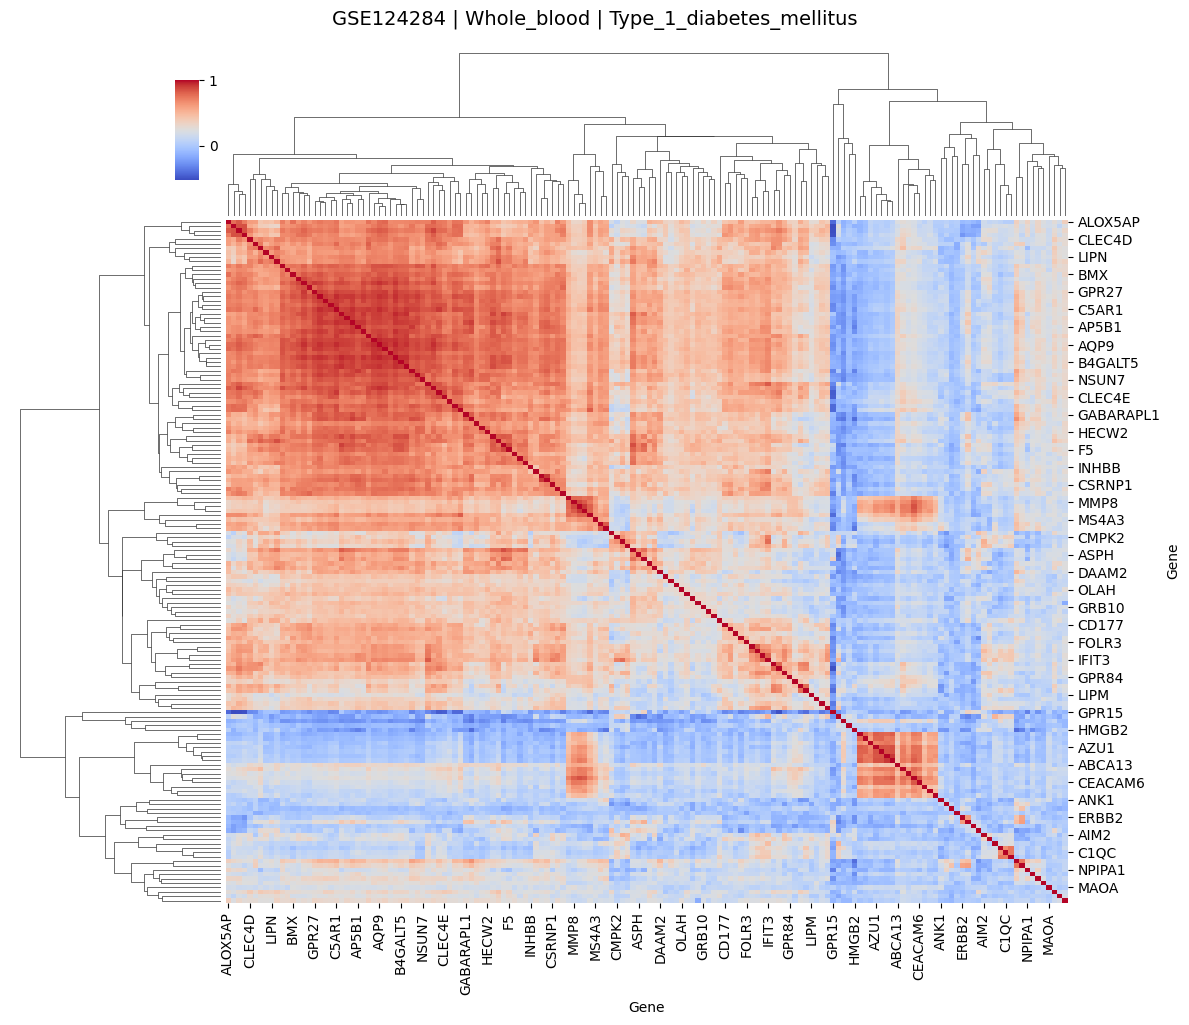

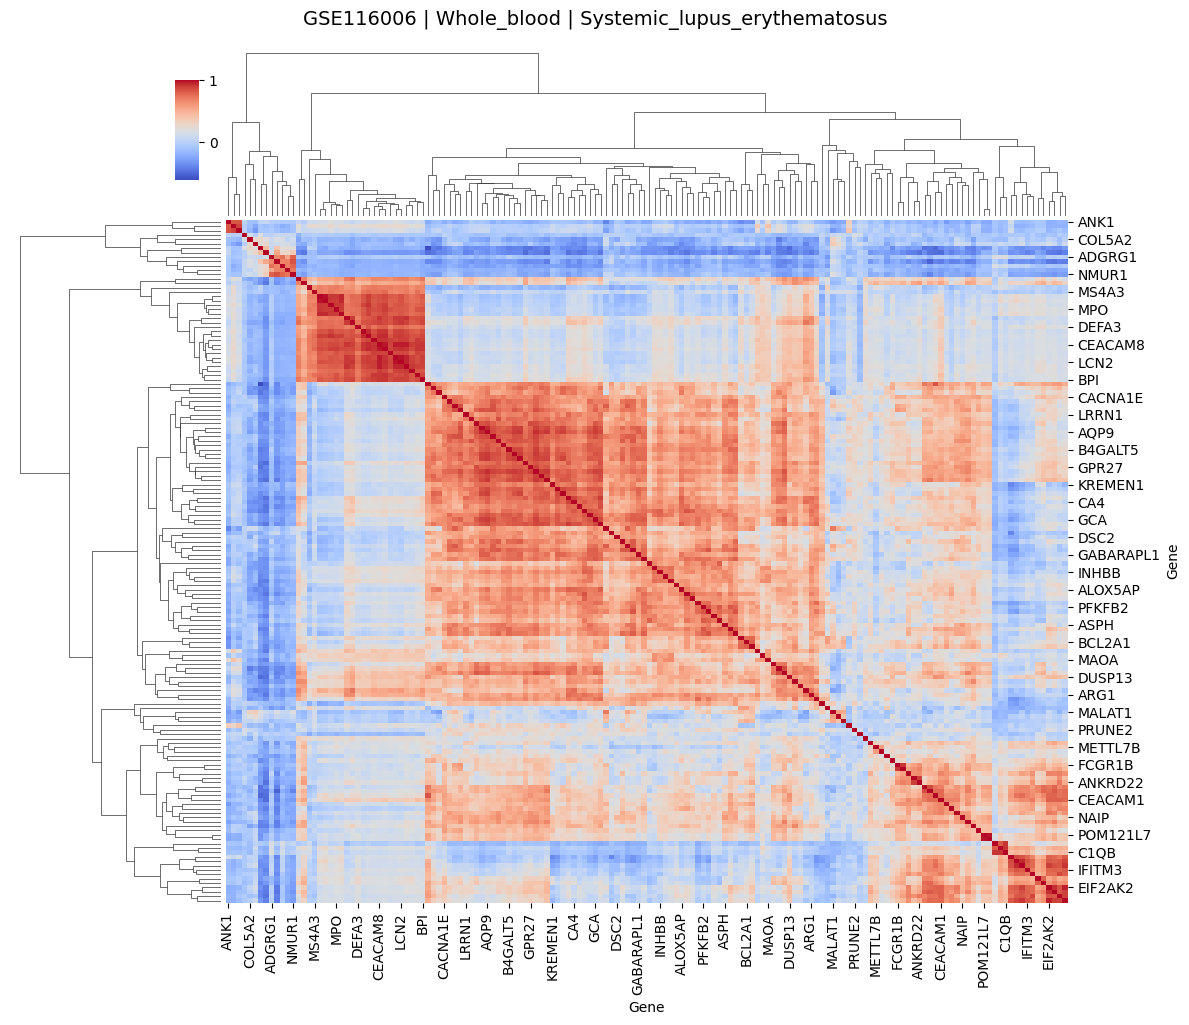

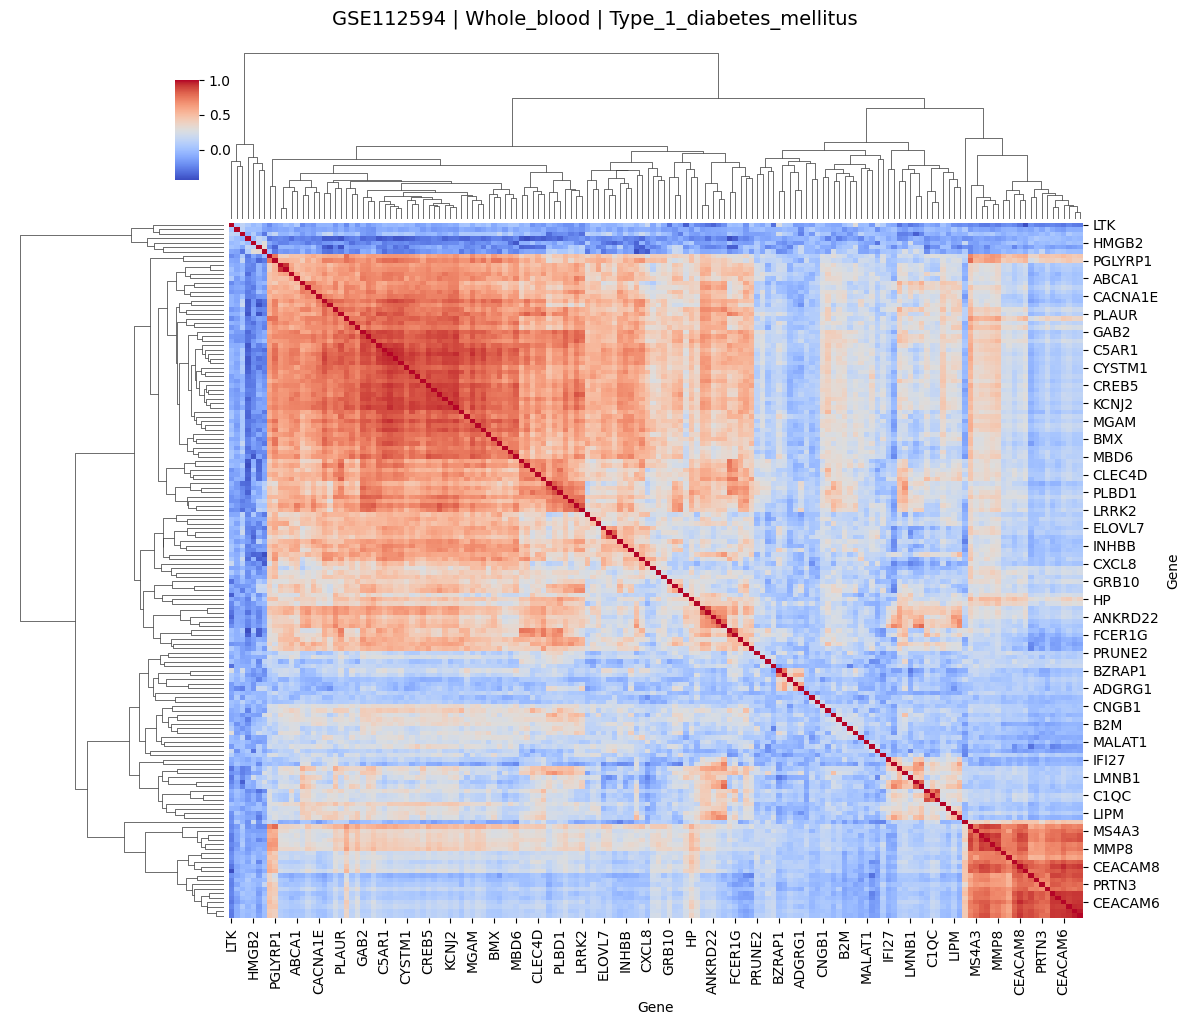

In [ ]:
datasets = ["GSE124400", "GSE143507", "GSE67401", "GSE124284", "GSE116006", "GSE112594"]

draw_clustermaps(
    expr,
    ann,
    "../data/stable_genes.txt",
    datasets,
    output_prefix="consensus",
    output_dir="../images/clustermaps",
)

# Consensus Clustermup and primary signatures list

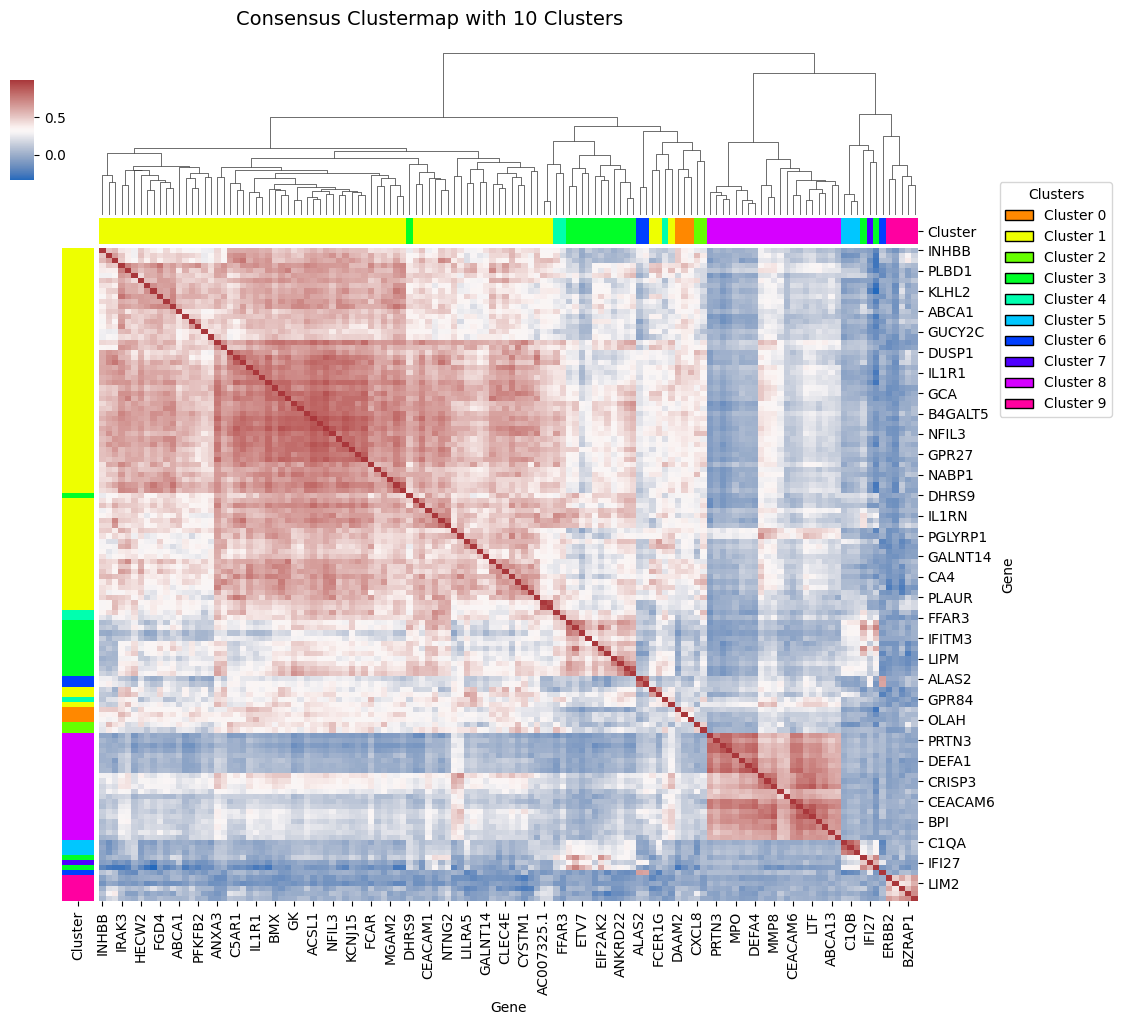

In [20]:
datasets = ["GSE124400", "GSE143507", "GSE67401", "GSE124284", "GSE116006", "GSE112594"]

clusters = draw_consensus_clustermap(
    expr,
    ann,
    "../data/stable_genes.txt",
    datasets,
    output_prefix="consensus",
    output_dir="../images/clustermaps",
    n_clusters=10,
    min_corr=0.55,
)

In [21]:
for cluster_id, genes in clusters.items():
    print(f"\nCluster {cluster_id} ({len(genes)} genes):")
    print(", ".join(genes))


Cluster 0 (3 genes):
DAAM2, KCNE1, OLAH

Cluster 1 (73 genes):
ABCA1, AC007325.1, ACSL1, ALOX5AP, ANXA3, AP5B1, AQP9, ARG1, ASPH, B4GALT5, BCL2A1, BMX, C5AR1, CA4, CACNA1E, CD177, CEACAM1, CLEC4D, CLEC4E, CR1, CREB5, CSTA, CYSTM1, DSC2, DUSP1, F5, FCAR, FCER1G, FGD4, FPR2, GAB2, GABARAPL1, GALNT14, GCA, GK, GPR27, GUCY2C, HECW2, HP, IFITM2, IL18R1, IL1R1, IL1R2, IL1RN, INHBB, IRAK3, KCNJ15, KCNJ2, KIAA0825, KLHL2, KREMEN1, LILRA5, LIPN, LRRK2, LRRN1, MARC1, MBD6, MCEMP1, MGAM, MGAM2, NABP1, NAIP, NAMPT, NFIL3, NSUN7, NTNG2, PFKFB2, PGLYRP1, PLAUR, PLBD1, POM121L7, PROK2, QPCT

Cluster 2 (2 genes):
CXCL8, G0S2

Cluster 3 (14 genes):
AIM2, ANKRD22, BATF2, CMPK2, DHRS9, EIF2AK2, ETV7, FCGR1A, FCGR1B, IFIT3, IFITM3, ISG15, LIPM, PLSCR1

Cluster 4 (3 genes):
CSRNP1, FFAR3, GPR84

Cluster 5 (3 genes):
C1QA, C1QB, C1QC

Cluster 6 (3 genes):
ALAS2, ANK1, CA1

Cluster 7 (1 genes):
IFI27

Cluster 8 (21 genes):
ABCA13, AZU1, BPI, CAMP, CEACAM6, CEACAM8, COL17A1, CRISP3, CTSG, DEFA1, DEFA3, DEFA4